In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import unit_impulse,fftconvolve,freqz, butter, residue, freqs
from numpy.lib.scimath import sqrt as csqrt
from scipy.special import iv
from scipy.fft import fft, fftfreq
pi = np.pi

## Project of a low-pass IIR filter by Impulse Invariance with a Butterworth Filter

In [42]:
def x(t): ## signal to be filtered
    y = np.cos(2*pi*60*t) + 2*np.cos(2*pi*600*t)
    return y

In [28]:
def h(n, A, poles): ## impulse response of the discrete-time filter
    response = np.zeros(len(n))
    for i in range(len(n)):
        parcel = 0
        for k in range(len(poles)): ## 'poles' are the poles of the transfer function of the continuous time filter
            parcel = parcel + A[k]*np.exp(poles[k]*n[i]) ## A[k] are the numerators of the partial expansion of the transfer function of the continuous time filter
        response[i] = parcel
    return response

In [2]:
def H(A, poles, omega): ## returns the system function of the discrete time filter by the impulse invariance method
    j = csqrt(-1)
    N = len(poles) ## 'poles' are the poles of the transfer function of the continuous time filter
    response = np.zeros(len(omega), dtype = 'complex')
    for i in range(len(omega)):
        parcel = 0
        for k in range(N):
            parcel = parcel + (A[k])/(1 - np.exp(-j*omega[i] + poles[k])) ## Z = exp(j*omega)
        response[i] = parcel
    return response

In [66]:
def Fourier(omega, h): ## Discrete Time Fourier Transform DTFT
    H = np.zeros(len(omega), dtype = 'complex')
    j = csqrt(-1)
    for i in range(len(omega)):
        parcel = 0
        for k in range(len(h)):
            parcel = parcel + h[k]*np.exp(-j*omega[i]*k)
        H[i] = parcel
    return H

## Filter Specifications

C:\Users\moise\AppData\Local\Temp\ipykernel_12776\2578061042.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  response[i] = parcel


Text(0.5, 1.0, 'log magnitude')

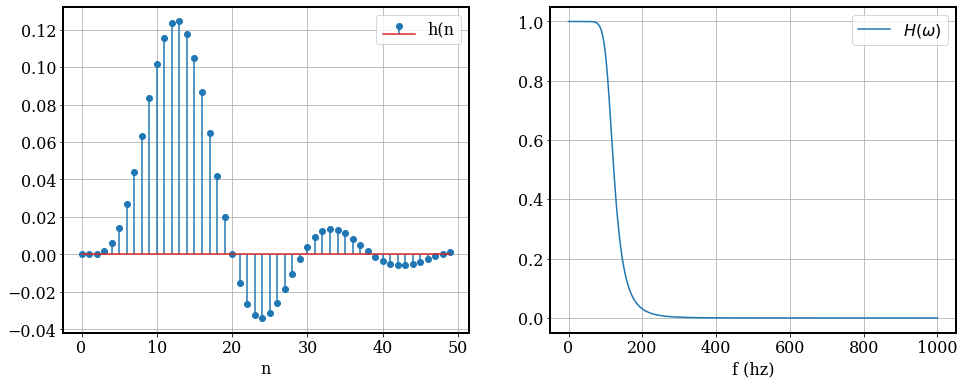

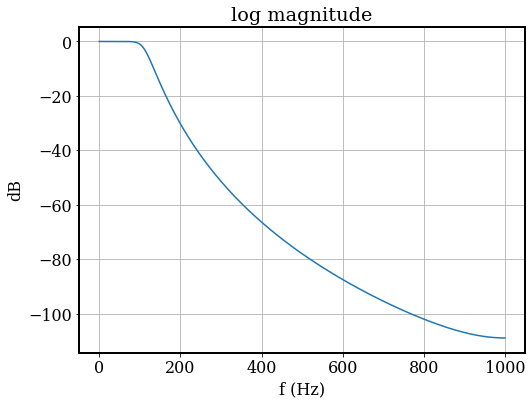

In [76]:
fs = 2000 ##Sampling rate
T = 1/fs
Omega_s = 2*pi*400 ## stop frequency
Omega_p = 2*pi*100 ## pass frequency
ws = Omega_s*T ## normalized frequency, omega = 2*pi*f*T, where T is the inverse of the sampling rate
wp = Omega_p*T

delta1 = 1 #dB ## maximum attneuation in the pass band
delta2 = 60 #dB ## mimimum attenuation in the stop band
atp = 10**(-delta1/20)
ats = 10**(-delta2/20)

order = np.log10((1/atp**2 - 1)/(1/ats**2 - 1))*1/(2*np.log10(Omega_p/Omega_s)) ## calculating the order of the filter
N = int(order) + 1 ## ther order must be an integer
Omega_c = wp*((1/atp**2 - 1)**(-0.5/N)) ## calculating Omega_c with the integer value of N

Hc = butter(N, Omega_c, btype = 'low',analog = 'True', output = 'ba') ## returning the transfer function of the continuous time Butterworth filter
Apart = residue(Hc[0], Hc[1]) ##  partial fraction expansion
Ak = Apart[0] ## numerators of the partial fraction expansion
sk = Apart[1] ## poles of the transfer function

n = np.arange(50)
hn = h(n, Ak, sk) ## h(n), impulse response of the discrete time filter by impulse invariance

freq = np.linspace(0, np.pi, 1000)
Hw = H(Ak, sk, freq) ## impulse response of the discrete time filter in the frequency domain by impulse invariance

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16} 
plt.rc('font', **font)
plt.rc('axes', linewidth=2)

figure, ax = plt.subplots(1, 2, figsize = (16, 6))
ax[0].stem(n, hn, label = 'h(n')
ax[0].grid(True)
ax[0].set_xlabel('n')
ax[0].legend(loc = 'upper right')

ax[1].plot(freq/(2*np.pi*T), abs(Hw), label = '$H(\omega)$')
ax[1].grid(True)
ax[1].set_xlabel('f (hz)')
ax[1].legend(loc = 'upper right')

figure = plt.figure(figsize = (8,6))
plt.plot(freq/(2*pi*T), 20*np.log10(abs(Hw)))
plt.grid(True)
plt.xlabel('f (Hz)')
plt.ylabel('dB')
plt.title('log magnitude')


## Filtering the Signal

Text(0.5, 1.0, '$Y(\\omega)$, filtered signal')

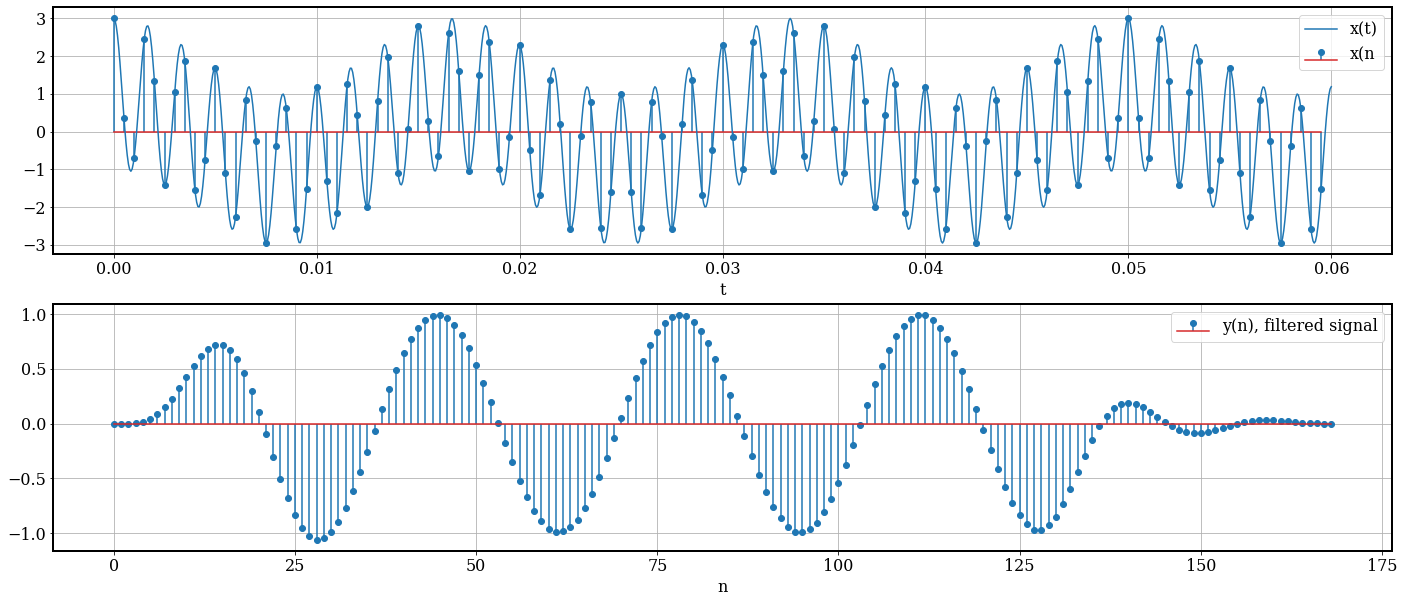

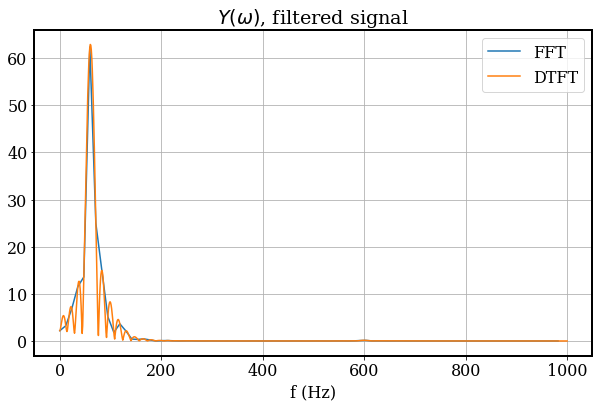

In [75]:
lim = 0.06
Samples = lim/T
t = np.linspace(0, lim, 1000)
k = np.arange(Samples)*T ## sampling the signal with sample rate 1/T

y = np.convolve(x(k), hn) ## y(n) = x(n)*h(n)
size = len(x(k)) + len(hn) - 1 ## length of the discrete convolution
position = np.arange(size)

freq = np.fft.fftfreq(int(size), d = T) ## FFT of y(n)
freq = freq[:freq.size//2] ## only the positive part of the spectrum
Y = np.fft.fft(y)
Y = Y[:Y.size//2] ## only the part where the domain is positive

a = np.linspace(0, pi, 1000)
b = Fourier(a, y) ## DTFT of the output signal, Discrete Time Fourier Transform

figure, ax = plt.subplots(2, 1, figsize = (24, 10))

ax[0].stem(k, x(k), label = 'x(n')
ax[0].plot(t, x(t), label = 'x(t)')
ax[0].grid(True)
ax[0].set_xlabel('t')
ax[0].legend(loc = 'upper right')

ax[1].stem(position, y, label = 'y(n), filtered signal')
ax[1].grid(True)
ax[1].set_xlabel('n')
ax[1].legend(loc = 'upper right')

figure = plt.figure(figsize = (10,6))
plt.plot(freq, abs(Y), label = 'FFT')
plt.grid(True)
plt.xlabel('f (Hz)')
plt.legend(loc = 'upper right')

plt.plot(a/(2*pi*T), abs(b), label = 'DTFT')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.title('$Y(\omega)$' + ', filtered signal')